<a href="https://colab.research.google.com/github/alberto20/AI-Lab3/blob/master/Ramirez_Ramirez_Capps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
from PIL import Image
import glob
import cv2
import zipfile
import os
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pathlib
import random
import h5py
from torch.utils.data import Dataset

#installs necessary plugins required
!pip install -q tensorboardX
!apt-get install p7zip-full
!apt install unzip

#creates data folder to store data in
!mkdir Data
!mkdir Code
#unzips training data
!unzip -uq "/content/gdrive/My Drive/singlecoil_train.zip" -d "/content/Data"
#unzips validation data
!unzip -uq "/content/gdrive/My Drive/singlecoil_val.zip" -d "/content/Data"
#unzips testing data
!unzip -uq "/content/gdrive/My Drive/singlecoil_test.zip" -d "/content/Data"

#unzips fastmri code files
!unzip -uq "/content/gdrive/My Drive/FastMri.zip" -d "/content/Code"



Using TensorFlow backend.


     |████████████████████████████████| 194kB 9.6MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [ ]:
#trains the unet model for the fastmri at 5 epochs, Research paper uses 50
%run /content/Code/FastMri/train_unet.py --challenge singlecoil --data-path /content/Data --exp-dir checkpoint
#runs runstats plugin install and runs unet model that was trained using the best model
!pip install runstats
%run /content/Code/FastMri/run_unet.py --data-path "/content/Data" --data-split val --checkpoint checkpoint/best_model.pt --challenge singlecoil --out-dir "/content/reconstructions_val" --mask-kspace
#evaluates reconstructed val images
%run /content/Code/FastMri/evaluate.py --target-path "/content/Data/singlecoil_val" --predictions-path "/content/reconstructions_val" --challenge singlecoil

#%run /content/Code/FastMri/run_unet.py --data-path "/content/Data" --data-split test --checkpoint checkpoint/best_model.pt --challenge singlecoil --out-dir reconstructions_test

INFO:root:Namespace(accelerations=[4, 8], batch_size=16, center_fractions=[0.08, 0.04], challenge='singlecoil', checkpoint=None, data_parallel=False, data_path=PosixPath('/content/Data'), device='cuda', drop_prob=0.0, exp_dir=PosixPath('checkpoint'), lr=0.001, lr_gamma=0.1, lr_step_size=40, num_chans=32, num_epochs=50, num_pools=4, report_interval=100, resolution=320, resume=False, sample_rate=1.0, seed=42, weight_decay=0.0)
INFO:root:UnetModel(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(in_chans=1, out_chans=32, drop_prob=0.0)
    (1): ConvBlock(in_chans=32, out_chans=64, drop_prob=0.0)
    (2): ConvBlock(in_chans=64, out_chans=128, drop_prob=0.0)
    (3): ConvBlock(in_chans=128, out_chans=256, drop_prob=0.0)
  )
  (conv): ConvBlock(in_chans=256, out_chans=256, drop_prob=0.0)
  (up_sample_layers): ModuleList(
    (0): ConvBlock(in_chans=512, out_chans=128, drop_prob=0.0)
    (1): ConvBlock(in_chans=256, out_chans=64, drop_prob=0.0)
    (2): ConvBlock(in_chans=128, out_chan

MSE = 1.867e-10 +/- 3.877e-10 NMSE = 0.05532 +/- 0.06095 PSNR = 28.72 +/- 5.493 SSIM = 0.6236 +/- 0.2861


<Figure size 432x288 with 0 Axes>

In [ ]:
%run /content/Code/FastMri/run_unet.py --data-path "/content/Data" --data-split test --checkpoint checkpoint/best_model.pt --challenge singlecoil --out-dir reconstructions_test

In [ ]:
"""
Copyright (c) Facebook, Inc. and its affiliates.
This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

import pathlib
import random

import h5py
from torch.utils.data import Dataset


class SliceData(Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """

    def __init__(self, root, transform, challenge, sample_rate=1):
        """
        Args:
            root (pathlib.Path): Path to the dataset.
            transform (callable): A callable object that pre-processes the raw data into
                appropriate form. The transform function should take 'kspace', 'target',
                'attributes', 'filename', and 'slice' as inputs. 'target' may be null
                for test data.
            challenge (str): "singlecoil" or "multicoil" depending on which challenge to use.
            sample_rate (float, optional): A float between 0 and 1. This controls what fraction
                of the volumes should be loaded.
        """
        if challenge not in ('singlecoil', 'multicoil'):
            raise ValueError('challenge should be either "singlecoil" or "multicoil"')

        self.transform = transform
        self.recons_key = 'reconstruction_esc' if challenge == 'singlecoil' \
            else 'reconstruction_rss'

        self.examples = []
        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]
        for fname in sorted(files):
            kspace = h5py.File(fname, 'r')['kspace']
            num_slices = kspace.shape[0]
            self.examples += [(fname, slice) for slice in range(num_slices)]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        fname, slice = self.examples[i]
        with h5py.File(fname, 'r') as data:
            kspace = data['kspace'][slice]
            target = data[self.recons_key][slice] if self.recons_key in data else None
            return self.transform(kspace, target, data.attrs, fname.name, slice)

In [ ]:
"""
Copyright (c) Facebook, Inc. and its affiliates.
This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

import numpy as np
import torch


def to_tensor(data):
    """
    Convert numpy array to PyTorch tensor. For complex arrays, the real and imaginary parts
    are stacked along the last dimension.
    Args:
        data (np.array): Input numpy array
    Returns:
        torch.Tensor: PyTorch version of data
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)
    return torch.from_numpy(data)


def apply_mask(data, mask_func, seed=None):
    """
    Subsample given k-space by multiplying with a mask.
    Args:
        data (torch.Tensor): The input k-space data. This should have at least 3 dimensions, where
            dimensions -3 and -2 are the spatial dimensions, and the final dimension has size
            2 (for complex values).
        mask_func (callable): A function that takes a shape (tuple of ints) and a random
            number seed and returns a mask.
        seed (int or 1-d array_like, optional): Seed for the random number generator.
    Returns:
        (tuple): tuple containing:
            masked data (torch.Tensor): Subsampled k-space data
            mask (torch.Tensor): The generated mask
    """
    shape = np.array(data.shape)
    shape[:-3] = 1
    mask = mask_func(shape, seed)
    return torch.where(mask == 0, torch.Tensor([0]), data), mask


def fft2(data):
    """
    Apply centered 2 dimensional Fast Fourier Transform.
    Args:
        data (torch.Tensor): Complex valued input data containing at least 3 dimensions: dimensions
            -3 & -2 are spatial dimensions and dimension -1 has size 2. All other dimensions are
            assumed to be batch dimensions.
    Returns:
        torch.Tensor: The FFT of the input.
    """
    assert data.size(-1) == 2
    data = ifftshift(data, dim=(-3, -2))
    data = torch.fft(data, 2, normalized=True)
    data = fftshift(data, dim=(-3, -2))
    return data


def ifft2(data):
    """
    Apply centered 2-dimensional Inverse Fast Fourier Transform.
    Args:
        data (torch.Tensor): Complex valued input data containing at least 3 dimensions: dimensions
            -3 & -2 are spatial dimensions and dimension -1 has size 2. All other dimensions are
            assumed to be batch dimensions.
    Returns:
        torch.Tensor: The IFFT of the input.
    """
    assert data.size(-1) == 2
    data = ifftshift(data, dim=(-3, -2))
    data = torch.ifft(data, 2, normalized=True)
    data = fftshift(data, dim=(-3, -2))
    return data


def complex_abs(data):
    """
    Compute the absolute value of a complex valued input tensor.
    Args:
        data (torch.Tensor): A complex valued tensor, where the size of the final dimension
            should be 2.
    Returns:
        torch.Tensor: Absolute value of data
    """
    assert data.size(-1) == 2
    return (data ** 2).sum(dim=-1).sqrt()


def root_sum_of_squares(data, dim=0):
    """
    Compute the Root Sum of Squares (RSS) transform along a given dimension of a tensor.
    Args:
        data (torch.Tensor): The input tensor
        dim (int): The dimensions along which to apply the RSS transform
    Returns:
        torch.Tensor: The RSS value
    """
    return torch.sqrt((data ** 2).sum(dim))


def center_crop(data, shape):
    """
    Apply a center crop to the input real image or batch of real images.
    Args:
        data (torch.Tensor): The input tensor to be center cropped. It should have at
            least 2 dimensions and the cropping is applied along the last two dimensions.
        shape (int, int): The output shape. The shape should be smaller than the
            corresponding dimensions of data.
    Returns:
        torch.Tensor: The center cropped image
    """
    assert 0 < shape[0] <= data.shape[-2]
    assert 0 < shape[1] <= data.shape[-1]
    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to]


def complex_center_crop(data, shape):
    """
    Apply a center crop to the input image or batch of complex images.
    Args:
        data (torch.Tensor): The complex input tensor to be center cropped. It should
            have at least 3 dimensions and the cropping is applied along dimensions
            -3 and -2 and the last dimensions should have a size of 2.
        shape (int, int): The output shape. The shape should be smaller than the
            corresponding dimensions of data.
    Returns:
        torch.Tensor: The center cropped image
    """
    assert 0 < shape[0] <= data.shape[-3]
    assert 0 < shape[1] <= data.shape[-2]
    w_from = (data.shape[-3] - shape[0]) // 2
    h_from = (data.shape[-2] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to, :]


def normalize(data, mean, stddev, eps=0.):
    """
    Normalize the given tensor using:
        (data - mean) / (stddev + eps)
    Args:
        data (torch.Tensor): Input data to be normalized
        mean (float): Mean value
        stddev (float): Standard deviation
        eps (float): Added to stddev to prevent dividing by zero
    Returns:
        torch.Tensor: Normalized tensor
    """
    return (data - mean) / (stddev + eps)


def normalize_instance(data, eps=0.):
    """
        Normalize the given tensor using:
            (data - mean) / (stddev + eps)
        where mean and stddev are computed from the data itself.
        Args:
            data (torch.Tensor): Input data to be normalized
            eps (float): Added to stddev to prevent dividing by zero
        Returns:
            torch.Tensor: Normalized tensor
        """
    mean = data.mean()
    std = data.std()
    return normalize(data, mean, std, eps), mean, std


# Helper functions

def roll(x, shift, dim):
    """
    Similar to np.roll but applies to PyTorch Tensors
    """
    if isinstance(shift, (tuple, list)):
        assert len(shift) == len(dim)
        for s, d in zip(shift, dim):
            x = roll(x, s, d)
        return x
    shift = shift % x.size(dim)
    if shift == 0:
        return x
    left = x.narrow(dim, 0, x.size(dim) - shift)
    right = x.narrow(dim, x.size(dim) - shift, shift)
    return torch.cat((right, left), dim=dim)


def fftshift(x, dim=None):
    """
    Similar to np.fft.fftshift but applies to PyTorch Tensors
    """
    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [dim // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = x.shape[dim] // 2
    else:
        shift = [x.shape[i] // 2 for i in dim]
    return roll(x, shift, dim)


def ifftshift(x, dim=None):
    """
    Similar to np.fft.ifftshift but applies to PyTorch Tensors
    """
    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [(dim + 1) // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = (x.shape[dim] + 1) // 2
    else:
        shift = [(x.shape[i] + 1) // 2 for i in dim]
    return roll(x, shift, dim)

In [ ]:
"""
Copyright (c) Facebook, Inc. and its affiliates.
This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

import numpy as np
import torch


class MaskFunc:
    """
    MaskFunc creates a sub-sampling mask of a given shape.
    The mask selects a subset of columns from the input k-space data. If the k-space data has N
    columns, the mask picks out:
        1. N_low_freqs = (N * center_fraction) columns in the center corresponding to
           low-frequencies
        2. The other columns are selected uniformly at random with a probability equal to:
           prob = (N / acceleration - N_low_freqs) / (N - N_low_freqs).
    This ensures that the expected number of columns selected is equal to (N / acceleration)
    It is possible to use multiple center_fractions and accelerations, in which case one possible
    (center_fraction, acceleration) is chosen uniformly at random each time the MaskFunc object is
    called.
    For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04], then there
    is a 50% probability that 4-fold acceleration with 8% center fraction is selected and a 50%
    probability that 8-fold acceleration with 4% center fraction is selected.
    """

    def __init__(self, center_fractions, accelerations):
        """
        Args:
            center_fractions (List[float]): Fraction of low-frequency columns to be retained.
                If multiple values are provided, then one of these numbers is chosen uniformly
                each time.
            accelerations (List[int]): Amount of under-sampling. This should have the same length
                as center_fractions. If multiple values are provided, then one of these is chosen
                uniformly each time. An acceleration of 4 retains 25% of the columns, but they may
                not be spaced evenly.
        """
        if len(center_fractions) != len(accelerations):
            raise ValueError('Number of center fractions should match number of accelerations')

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def __call__(self, shape, seed=None):
        """
        Args:
            shape (iterable[int]): The shape of the mask to be created. The shape should have
                at least 3 dimensions. Samples are drawn along the second last dimension.
            seed (int, optional): Seed for the random number generator. Setting the seed
                ensures the same mask is generated each time for the same shape.
        Returns:
            torch.Tensor: A mask of the specified shape.
        """
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')

        self.rng.seed(seed)
        num_cols = shape[-2]

        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        # Create the mask
        num_low_freqs = int(round(num_cols * center_fraction))
        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = self.rng.uniform(size=num_cols) < prob
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        # Reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

        return mask

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'num_low_frequency': 15, 'patient_id': 'e0dfa45d736bc5351e278a708765827c305f9393bb3b9c0beabee929ccab8e3e', 'acquisition': 'CORPDFS_FBK'}
complex64
(34, 640, 372)


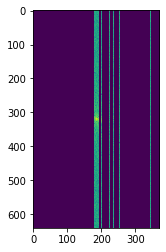

In [ ]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt


file = '/content/Data/singlecoil_test/file1000679_v2.h5'
hf = h5py.File(file)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

print(volume_kspace.dtype)
print(volume_kspace.shape)

slice_nums = [0]
fig = plt.figure()
for i, num in enumerate(slice_nums):
  plt.subplot(1, len(slice_nums), i + 1)
  plt.imshow((np.log(np.abs(slice_kspace) + 1e-9)), cmap=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


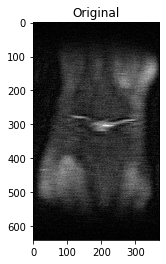

In [ ]:
slice_kspace2 = to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = complex_abs(slice_image)
labels = ["Original"]
fig = plt.figure()
for i, num in enumerate(slice_nums):
  plt.title(labels[num])
  plt.subplot(1, len(slice_nums), i + 1)
  plt.imshow(slice_image_abs,cmap='gray')

Keys: ['reconstruction']
Attrs: {}
float32
(34, 320, 320)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


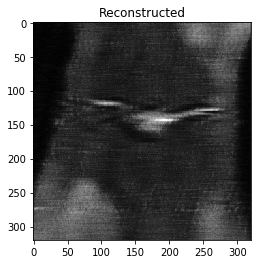

In [ ]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt


file2 = '/content/reconstructions_test/file1000679_v2.h5'
hf = h5py.File(file2)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

file2_volume_kspace = hf['reconstruction'][()]

file2_slice_kspace = file2_volume_kspace[20] # Choosing the 20-th slice of this volume

print(file2_volume_kspace.dtype)
print(file2_volume_kspace.shape)

file2_slice_kspace2 = to_tensor(file2_slice_kspace)      # Convert from numpy array to pytorch tensor

labels = ["Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_nums):
  plt.title(labels[num])
  plt.subplot(1, len(slice_nums), i + 1)
  plt.imshow(file2_slice_kspace2,cmap='gray')


print("Reconstruction of 5 apochs")


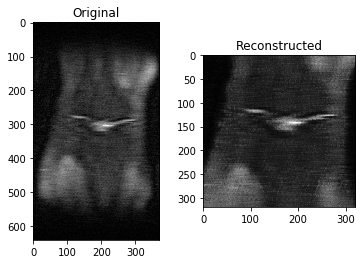

In [ ]:
slice_num = [0,1]
data = [slice_image_abs,file2_slice_kspace2]
labels = ["Original", "Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_num):
  plt.subplot(1, len(slice_num), i + 1)
  plt.title(labels[num])
  plt.imshow(data[num],cmap='gray')

Keys: ['reconstruction']
Attrs: {}
float32
(34, 320, 320)
Reconstruction from the training with 50 apochs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


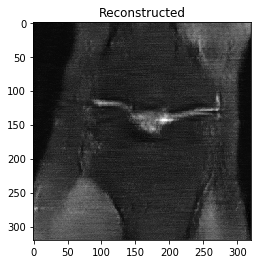

In [ ]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt


file2 = '/content/reconstructions_test/file1000679_v2.h5'
hf = h5py.File(file2)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

file2_volume_kspace = hf['reconstruction'][()]

file2_slice_kspace = file2_volume_kspace[20] # Choosing the 20-th slice of this volume

print(file2_volume_kspace.dtype)
print(file2_volume_kspace.shape)

file2_slice_kspace2 = to_tensor(file2_slice_kspace)      # Convert from numpy array to pytorch tensor

labels = ["Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_nums):
  plt.title(labels[num])
  plt.subplot(1, len(slice_nums), i + 1)
  plt.imshow(file2_slice_kspace2,cmap='gray')

print("Reconstruction from the training with 50 apochs")

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'num_low_frequency': 15, 'patient_id': 'e24dd3dc05085077e65af05fc5d4c439e5e338e58926c4f344274080bd7f7cdd', 'acquisition': 'CORPDFS_FBK'}
complex64
(37, 640, 368)


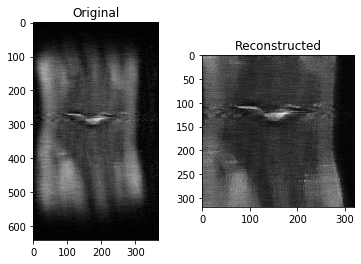

In [ ]:
#Original Image

file = '/content/Data/singlecoil_test/file1000022_v2.h5'
hf = h5py.File(file)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

print(volume_kspace.dtype)
print(volume_kspace.shape)

slice_kspace2 = to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = complex_abs(slice_image)

#Reconstructed image
file2 = '/content/reconstructions_test/file1000022_v2.h5'
hf = h5py.File(file2)

file2_volume_kspace = hf['reconstruction'][()]

file2_slice_kspace = file2_volume_kspace[20] # Choosing the 20-th slice of this volume

file2_slice_kspace2 = to_tensor(file2_slice_kspace)      # Convert from numpy array to pytorch tensor

slice_num = [0,1]
data = [slice_image_abs,file2_slice_kspace2]
labels = ["Original", "Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_num):
  plt.subplot(1, len(slice_num), i + 1)
  plt.title(labels[num])
  plt.imshow(data[num],cmap='gray')

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'num_low_frequency': 15, 'patient_id': 'e24dd3dc05085077e65af05fc5d4c439e5e338e58926c4f344274080bd7f7cdd', 'acquisition': 'CORPDFS_FBK'}
complex64
(37, 640, 368)
Reconstruction from the training with 50 apochs


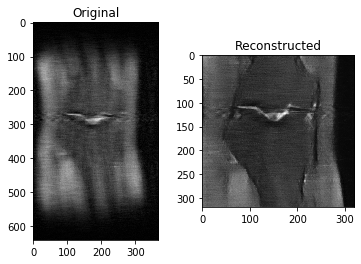

In [ ]:
#Original Image

file = '/content/Data/singlecoil_test/file1000022_v2.h5'
hf = h5py.File(file)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

print(volume_kspace.dtype)
print(volume_kspace.shape)

slice_kspace2 = to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = complex_abs(slice_image)

#Reconstructed image
file2 = '/content/reconstructions_test/file1000022_v2.h5'
hf = h5py.File(file2)

file2_volume_kspace = hf['reconstruction'][()]

file2_slice_kspace = file2_volume_kspace[20] # Choosing the 20-th slice of this volume

file2_slice_kspace2 = to_tensor(file2_slice_kspace)      # Convert from numpy array to pytorch tensor

slice_num = [0,1]
data = [slice_image_abs,file2_slice_kspace2]
labels = ["Original", "Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_num):
  plt.subplot(1, len(slice_num), i + 1)
  plt.title(labels[num])
  plt.imshow(data[num],cmap='gray')

print("Reconstruction from the training with 50 apochs")

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'num_low_frequency': 15, 'patient_id': 'd26849b8d06d857a253661f2700cbee0fdc18f6d1f56a9dfe814abc7e4e93ea4', 'acquisition': 'CORPD_FBK'}
complex64
(33, 640, 372)


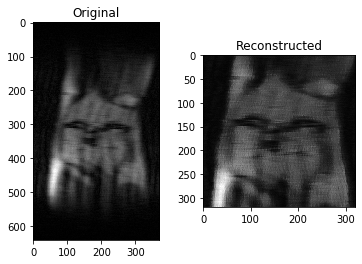

In [ ]:
#Original Image

file = '/content/Data/singlecoil_test/file1000036_v2.h5'
hf = h5py.File(file)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

print(volume_kspace.dtype)
print(volume_kspace.shape)

slice_kspace2 = to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = complex_abs(slice_image)

#Reconstructed image
file2 = '/content/reconstructions_test/file1000036_v2.h5'
hf = h5py.File(file2)

file2_volume_kspace = hf['reconstruction'][()]

file2_slice_kspace = file2_volume_kspace[20] # Choosing the 20-th slice of this volume

file2_slice_kspace2 = to_tensor(file2_slice_kspace)      # Convert from numpy array to pytorch tensor

slice_num = [0,1]
data = [slice_image_abs,file2_slice_kspace2]
labels = ["Original", "Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_num):
  plt.subplot(1, len(slice_num), i + 1)
  plt.title(labels[num])
  plt.imshow(data[num],cmap='gray')

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'num_low_frequency': 15, 'patient_id': 'd26849b8d06d857a253661f2700cbee0fdc18f6d1f56a9dfe814abc7e4e93ea4', 'acquisition': 'CORPD_FBK'}
complex64
(33, 640, 372)
Reconstruction from the training with 50 apochs


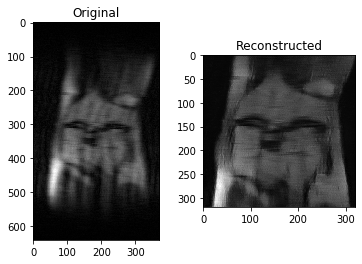

In [ ]:
#Original Image

file = '/content/Data/singlecoil_test/file1000036_v2.h5'
hf = h5py.File(file)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

print(volume_kspace.dtype)
print(volume_kspace.shape)

slice_kspace2 = to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = complex_abs(slice_image)

#Reconstructed image
file2 = '/content/reconstructions_test/file1000036_v2.h5'
hf = h5py.File(file2)

file2_volume_kspace = hf['reconstruction'][()]

file2_slice_kspace = file2_volume_kspace[20] # Choosing the 20-th slice of this volume

file2_slice_kspace2 = to_tensor(file2_slice_kspace)      # Convert from numpy array to pytorch tensor

slice_num = [0,1]
data = [slice_image_abs,file2_slice_kspace2]
labels = ["Original", "Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_num):
  plt.subplot(1, len(slice_num), i + 1)
  plt.title(labels[num])
  plt.imshow(data[num],cmap='gray')

print("Reconstruction from the training with 50 apochs")

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'num_low_frequency': 15, 'patient_id': '353105909d427bcc332309a10f09063507394efd09c28b6f9466d7db54d1bfd1', 'acquisition': 'CORPD_FBK'}
complex64
(41, 640, 368)


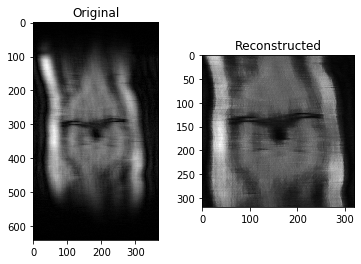

In [ ]:
#Original Image

file = '/content/Data/singlecoil_test/file1000455_v2.h5'
hf = h5py.File(file)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

print(volume_kspace.dtype)
print(volume_kspace.shape)

slice_kspace2 = to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = complex_abs(slice_image)

#Reconstructed image
file2 = '/content/reconstructions_test/file1000455_v2.h5'
hf = h5py.File(file2)

file2_volume_kspace = hf['reconstruction'][()]

file2_slice_kspace = file2_volume_kspace[20] # Choosing the 20-th slice of this volume

file2_slice_kspace2 = to_tensor(file2_slice_kspace)      # Convert from numpy array to pytorch tensor

slice_num = [0,1]
data = [slice_image_abs,file2_slice_kspace2]
labels = ["Original", "Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_num):
  plt.subplot(1, len(slice_num), i + 1)
  plt.title(labels[num])
  plt.imshow(data[num],cmap='gray')

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'num_low_frequency': 15, 'patient_id': '353105909d427bcc332309a10f09063507394efd09c28b6f9466d7db54d1bfd1', 'acquisition': 'CORPD_FBK'}
complex64
(41, 640, 368)
Reconstruction from the training with 50 apochs


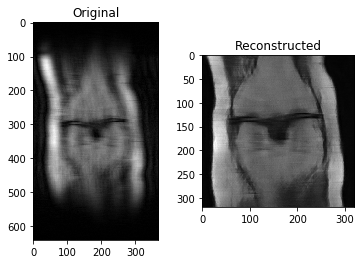

In [ ]:
#Original Image

file = '/content/Data/singlecoil_test/file1000455_v2.h5'
hf = h5py.File(file)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

print(volume_kspace.dtype)
print(volume_kspace.shape)

slice_kspace2 = to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = complex_abs(slice_image)

#Reconstructed image
file2 = '/content/reconstructions_test/file1000455_v2.h5'
hf = h5py.File(file2)

file2_volume_kspace = hf['reconstruction'][()]

file2_slice_kspace = file2_volume_kspace[20] # Choosing the 20-th slice of this volume

file2_slice_kspace2 = to_tensor(file2_slice_kspace)      # Convert from numpy array to pytorch tensor

slice_num = [0,1]
data = [slice_image_abs,file2_slice_kspace2]
labels = ["Original", "Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_num):
  plt.subplot(1, len(slice_num), i + 1)
  plt.title(labels[num])
  plt.imshow(data[num],cmap='gray')

print("Reconstruction from the training with 50 apochs")

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 4, 'num_low_frequency': 30, 'patient_id': '02bfd0342382f34997599e41d3b99171aedd7c1a798f86b0ec473fcb7833f301', 'acquisition': 'CORPDFS_FBK'}
complex64
(33, 640, 372)


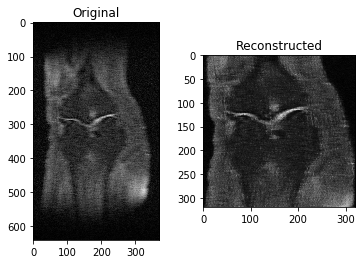

In [ ]:
#Original Image

file = '/content/Data/singlecoil_test/file1000513_v2.h5'
hf = h5py.File(file)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

print(volume_kspace.dtype)
print(volume_kspace.shape)

slice_kspace2 = to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = complex_abs(slice_image)

#Reconstructed image
file2 = '/content/reconstructions_test/file1000513_v2.h5'
hf = h5py.File(file2)

file2_volume_kspace = hf['reconstruction'][()]

file2_slice_kspace = file2_volume_kspace[20] # Choosing the 20-th slice of this volume

file2_slice_kspace2 = to_tensor(file2_slice_kspace)      # Convert from numpy array to pytorch tensor

slice_num = [0,1]
data = [slice_image_abs,file2_slice_kspace2]
labels = ["Original", "Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_num):
  plt.subplot(1, len(slice_num), i + 1)
  plt.title(labels[num])
  plt.imshow(data[num],cmap='gray')

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 4, 'num_low_frequency': 30, 'patient_id': '02bfd0342382f34997599e41d3b99171aedd7c1a798f86b0ec473fcb7833f301', 'acquisition': 'CORPDFS_FBK'}
complex64
(33, 640, 372)
Reconstruction from the training with 50 apochs


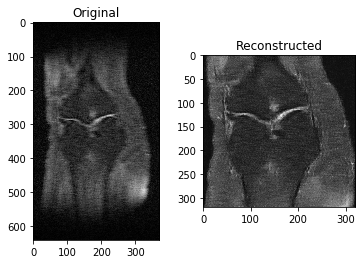

In [ ]:
#Original Image

file = '/content/Data/singlecoil_test/file1000513_v2.h5'
hf = h5py.File(file)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

volume_kspace = hf['kspace'][()]

slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

print(volume_kspace.dtype)
print(volume_kspace.shape)

slice_kspace2 = to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = complex_abs(slice_image)

#Reconstructed image
file2 = '/content/reconstructions_test/file1000513_v2.h5'
hf = h5py.File(file2)

file2_volume_kspace = hf['reconstruction'][()]

file2_slice_kspace = file2_volume_kspace[20] # Choosing the 20-th slice of this volume

file2_slice_kspace2 = to_tensor(file2_slice_kspace)      # Convert from numpy array to pytorch tensor

slice_num = [0,1]
data = [slice_image_abs,file2_slice_kspace2]
labels = ["Original", "Reconstructed"]
fig = plt.figure()
for i, num in enumerate(slice_num):
  plt.subplot(1, len(slice_num), i + 1)
  plt.title(labels[num])
  plt.imshow(data[num],cmap='gray')

print("Reconstruction from the training with 50 apochs")